<a href="https://colab.research.google.com/github/fubotz/ICL_2024W/blob/main/FinalProject_Fabian_SCHAMBECK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICL Final Project: Finetuning a Pretrained Multilingual Model for Cognate Detection

Model: xlm-roberta-base

Dataset: custom dataset containing en-fr cognates (Frossard et al.)

Method: [MASK] approach

In [101]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install torch

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset ##

In [103]:
!wget https://raw.githubusercontent.com/fubotz/ICL_2024W/refs/heads/main/word_pairs.json        # dataset taken from Frossard et al.

--2025-02-04 20:29:56--  https://raw.githubusercontent.com/fubotz/ICL_2024W/refs/heads/main/word_pairs.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23242 (23K) [text/plain]
Saving to: ‘word_pairs.json.5’

word_pairs.json.5   100%[===================>]  22.70K  --.-KB/s    in 0.008s  

2025-02-04 20:29:57 (2.78 MB/s) - ‘word_pairs.json.5’ saved [23242/23242]



In [104]:
import json
with open("word_pairs.json", "r") as f:
    dataset = json.load(f)
print(dataset)

[{'abandon': 'abandon'}, {'abbe': 'abbé'}, {'abdomen': 'abdomen'}, {'abdominal': 'abdominal'}, {'aberration': 'aberration'}, {'abolition': 'abolition'}, {'abominable': 'abominable'}, {'absence': 'absence'}, {'absolute': 'absolu'}, {'absolution': 'absolution'}, {'absorption': 'absorption'}, {'abstinence': 'abstinence'}, {'abstraction': 'abstraction'}, {'absurd': 'absurde'}, {'absurdity': 'absurdité'}, {'abundance': 'abondance'}, {'abundant': 'abondant'}, {'academic': 'académique'}, {'academy': 'académie'}, {'acceleration': 'accélération'}, {'accent': 'accent'}, {'acceptable': 'acceptable'}, {'access': 'accès'}, {'accessory': 'accessoire'}, {'accident': 'accident'}, {'accidental': 'accidentel'}, {'accidentally': 'accidentellement'}, {'acclamation': 'acclamation'}, {'accord': 'accord'}, {'acetone': 'acétone'}, {'acid': 'acide'}, {'acoustic': 'acoustique'}, {'activity': 'activité'}, {'actor': 'acteur'}, {'addition': 'addition'}, {'address': 'addresse'}, {'adherent': 'adhérent'}, {'administ

In [105]:
import random

# Shuffle the dataset
random.shuffle(dataset)

# Calculate the split indices
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)

# Create train, validation, and test splits (70:20:10)
train_data = dataset[:train_size]
val_data = dataset[train_size:train_size + val_size]
test_data = dataset[train_size + val_size:]

# Verify the split sizes
print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Total samples: 492
Training samples: 344
Validation samples: 98
Test samples: 50


## Load Model ##

In [106]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Model for [MASK] approach
pretrained_model = AutoModelForMaskedLM.from_pretrained(model_name)

for param in pretrained_model.base_model.parameters():
    param.requires_grad = False     # Freeze everything first

for param in pretrained_model.base_model.encoder.layer[-8:].parameters():
    param.requires_grad = True      # Unfreeze last x layers

print(tokenizer)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)


## Preprocessing for [MASK] Evaluation ##

In [107]:
import torch

# Define the evaluation function
def evaluate_mask_accuracy(model, test_data, tokenizer, top_k=5):
    """
    Evaluates the accuracy of a masked language model on a cognate dataset.

    Args:
        model: The pretrained or fine-tuned masked language model.
        test_data (list of dict): Dataset with English-French cognate pairs.
        tokenizer: The tokenizer corresponding to the model.
        top_k (int): Number of top predictions to consider for accuracy.

    Returns:
        float: Accuracy of the model on the dataset.
    """
    correct_predictions = 0
    total_samples = len(test_data)

    for i, pair in enumerate(test_data):
        # Extract the English word and expected French cognate
        english_word, french_word = list(pair.items())[0]

        # Use the mask token for the tokenizer
        mask_token = tokenizer.mask_token
        sentence = f"The English word is: {english_word}. Le mot français est: {mask_token}."
        inputs = tokenizer(sentence, return_tensors="pt")
        mask_token_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        if len(mask_token_index[0]) == 0:       # If no [MASK] token is found
            print(f"Error: No {mask_token} token found in instance {i+1}")
            continue

        mask_token_index = mask_token_index[1]

        # Forward pass through the model
        outputs = model(**inputs)
        logits = outputs.logits

        # Get top-k predictions for the [MASK] token
        mask_token_logits = logits[0, mask_token_index, :]
        top_k_tokens = torch.topk(mask_token_logits, k=top_k, dim=1).indices[0].tolist()
        predicted_words = [tokenizer.decode([token]).strip() for token in top_k_tokens]

        # Log predictions
        print(f"Instance {i+1}:")
        print(f"  English word: {english_word}")
        print(f"  Expected French word: {french_word}")
        print(f"  Predicted MASK words: {predicted_words}\n")

        # Check if the expected French word is in the predictions
        if french_word in predicted_words:
            correct_predictions += 1

    # Compute accuracy
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    return accuracy


# Evaluate the accuracy of pretrained model
accuracy = evaluate_mask_accuracy(pretrained_model, test_data, tokenizer, top_k=5)
print(f"Accuracy of the model: {accuracy:.2%}")

Instance 1:
  English word: accidentally
  Expected French word: accidentellement
  Predicted MASK words: ['accident', 'Accident', 'accidente', 'incident', ':']

Instance 2:
  English word: acclamation
  Expected French word: acclamation
  Predicted MASK words: ['expression', 'excuse', 'appel', 'opposition', 'pardon']

Instance 3:
  English word: adventure
  Expected French word: aventure
  Predicted MASK words: ['adventure', 'aventure', 'voyage', 'Adventure', 'imagination']

Instance 4:
  English word: music
  Expected French word: musique
  Predicted MASK words: ['music', 'musique', 'concert', 'Music', 'art']

Instance 5:
  English word: longitude
  Expected French word: longitude
  Predicted MASK words: ['longitud', 'longueur', 'long', 'distance', 'angle']

Instance 6:
  English word: circumstance
  Expected French word: circonstance
  Predicted MASK words: ['situation', 'conditions', 'observation', 'condition', 'exception']

Instance 7:
  English word: quest
  Expected French word:

## Preprocess Dataset ##

In [108]:
from torch.utils.data import DataLoader

# Preprocessing function
def preprocess_function(examples):
    """
    Preprocess examples by tokenizing English and French text and preparing input and label tensors.
    """
    # Extract inputs and targets
    inputs = examples["word_en"]        # List of English words
    targets = examples["word_fr"]       # List of French words

    # Tokenize inputs and targets (words so max_length=8)
    model_inputs = tokenizer(inputs, max_length=8, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=8, truncation=True, padding="max_length")["input_ids"]

    # Replace padding tokens in labels with -100
    model_inputs["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in seq] for seq in labels
    ]

    return model_inputs

In [109]:
from datasets import Dataset

# Convert raw data into the correct format
formatted_train_data = [{"word_en": k, "word_fr": v} for item in train_data for k, v in item.items()]
formatted_val_data = [{"word_en": k, "word_fr": v} for item in val_data for k, v in item.items()]
formatted_test_data = [{"word_en": k, "word_fr": v} for item in test_data for k, v in item.items()]

# Create Hugging Face datasets
train_dataset = Dataset.from_list(formatted_train_data)
val_dataset = Dataset.from_list(formatted_val_data)
test_dataset = Dataset.from_list(formatted_test_data)

In [110]:
# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [111]:
# Inspect a preprocessed example from the training set
print("\nSample preprocessed training example:")
sample_train_example = train_dataset[0]     # First example in train
print(sample_train_example)

# Decode the input IDs and labels to verify correctness
decoded_input = tokenizer.decode(sample_train_example["input_ids"].tolist(), skip_special_tokens=True)
decoded_label = tokenizer.decode(
    [token for token in sample_train_example["labels"].tolist() if token != -100], skip_special_tokens=True
)

print("\nDecoded Training Example:")
print(f"Input (word_en): {decoded_input}")
print(f"Label (word_fr): {decoded_label}")

# Verify dataset sizes after preprocessing
print(f"\nFinal dataset sizes:")
print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")


Sample preprocessed training example:
{'input_ids': tensor([   0, 6397,    2,    1,    1,    1,    1,    1]), 'attention_mask': tensor([1, 1, 1, 0, 0, 0, 0, 0]), 'labels': tensor([    0, 31360,   289,     2,  -100,  -100,  -100,  -100])}

Decoded Training Example:
Input (word_en): ideal
Label (word_fr): idéal

Final dataset sizes:
Training set: 344
Validation set: 98
Test set: 50


## Finetune Model ##

In [112]:
from transformers import TrainingArguments
import evaluate
import numpy as np

# Load accuracy metric
accuracy = evaluate.load("accuracy")

# Define metric computation function
def compute_metrics(eval_pred):
    """
    Computes accuracy during validation by ignoring padding tokens.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Flatten predictions and labels (remove -100 labels)
    flattened_predictions = []
    flattened_labels = []

    for pred, label in zip(predictions, labels):
        for p, l in zip(pred, label):
            if l != -100:       # Ignore padding token labels
                flattened_predictions.append(p)
                flattened_labels.append(l)

    return accuracy.compute(predictions=flattened_predictions, references=flattened_labels)

In [113]:
from transformers import Trainer, DataCollatorForLanguageModeling

# Define Data Collator with increased MASK probability
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,       # Enable masked language modeling
    mlm_probability=0.4     # Increase from default 0.15 to 0.4
)

# Define training arguments
arguments = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/cognate_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=8,
    num_train_epochs=6,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    gradient_accumulation_steps=2,
    weight_decay=0.03,
    load_best_model_at_end=True,
    report_to='none',
    seed=224
)

# Initialize the Trainer
trainer = Trainer(
    model=pretrained_model,
    args=arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,       # NB: change for test
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [114]:
# Verify dataset format
from torch.utils.data import DataLoader

# Create a DataLoader for debugging
debug_loader = DataLoader(train_dataset, batch_size=8)

# Get a batch
batch = next(iter(debug_loader))
print(batch)

# Print shapes
print(f"Input IDs shape: {batch['input_ids'].shape}")
print(f"Attention Mask shape: {batch['attention_mask'].shape}")
print(f"Labels shape: {batch['labels'].shape}")

{'input_ids': tensor([[     0,   6397,      2,      1,      1,      1,      1,      1],
        [     0, 226406,     13,      2,      1,      1,      1,      1],
        [     0,     10,  12600,  28692,      2,      1,      1,      1],
        [     0,  21640,      2,      1,      1,      1,      1,      1],
        [     0, 195734,      2,      1,      1,      1,      1,      1],
        [     0,  11417,     31,  48461,    289,      2,      1,      1],
        [     0,  14012,      2,      1,      1,      1,      1,      1],
        [     0, 127663,      2,      1,      1,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0]]), 'labels': tensor([[     0,  31360,    289,      2,   -100,   -100,   -100,   -100],
        [     0,

In [115]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,8.886300,3.402546,0.666667
2,7.879700,2.962822,0.677165
3,5.668700,2.853352,0.690289
4,5.531200,2.749221,0.695538
5,4.995600,2.700511,0.695538
6,5.461600,2.679568,0.698163


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


TrainOutput(global_step=66, training_loss=6.191344781355425, metrics={'train_runtime': 259.1707, 'train_samples_per_second': 7.964, 'train_steps_per_second': 0.255, 'total_flos': 8510099535360.0, 'train_loss': 6.191344781355425, 'epoch': 6.0})

In [116]:
# Save the trained model
output_dir = "/content/drive/MyDrive/Colab Notebooks/cognate_trainer_best_model"
trainer.save_model(output_dir)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)

print("\nTest Results:")
print(test_results)


Test Results:
{'eval_loss': 1.9808121919631958, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 2.1582, 'eval_samples_per_second': 23.168, 'eval_steps_per_second': 1.853, 'epoch': 6.0}


In [117]:
# Load finetuned model
finetuned_model = AutoModelForMaskedLM.from_pretrained(output_dir)

## Evaluate Finetuned Model ##

In [118]:
# Evaluate the accuracy of finetuned model
accuracy = evaluate_mask_accuracy(finetuned_model, test_data, tokenizer, top_k=5)
print(f"Accuracy of the model: {accuracy:.2%}")

Instance 1:
  English word: accidentally
  Expected French word: accidentellement
  Predicted MASK words: ['accident', 'accidente', 'Accident', 'incident', 'accident']

Instance 2:
  English word: acclamation
  Expected French word: acclamation
  Predicted MASK words: ['appel', 'réaction', 'accord', 'commentaire', 'excuse']

Instance 3:
  English word: adventure
  Expected French word: aventure
  Predicted MASK words: ['aventure', 'adventure', 'expérience', 'aventure', 'voyage']

Instance 4:
  English word: music
  Expected French word: musique
  Predicted MASK words: ['musique', 'music', 'concert', 'musical', 'cinéma']

Instance 5:
  English word: longitude
  Expected French word: longitude
  Predicted MASK words: ['longueur', 'longitud', 'hauteur', 'long', 'moyenne']

Instance 6:
  English word: circumstance
  Expected French word: circonstance
  Predicted MASK words: ['nécessité', 'situation', 'résistance', 'observation', 'incident']

Instance 7:
  English word: quest
  Expected Fre

## Visualization ##

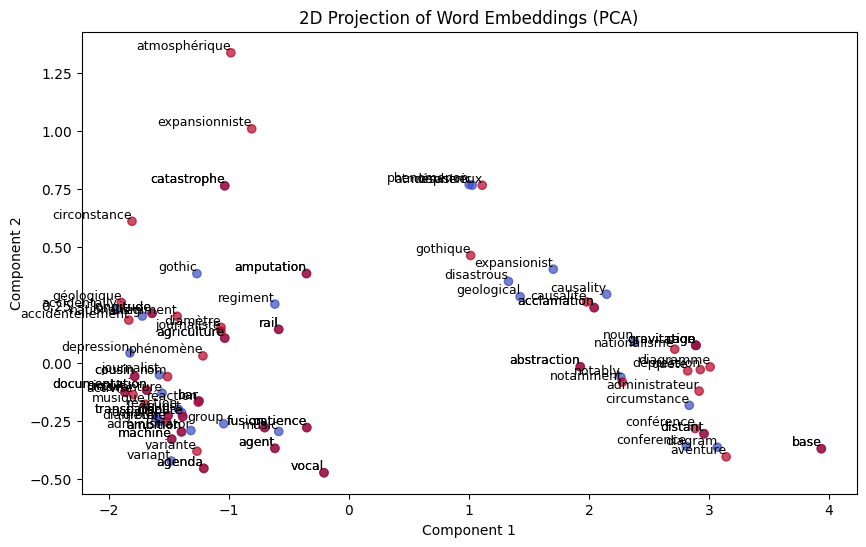

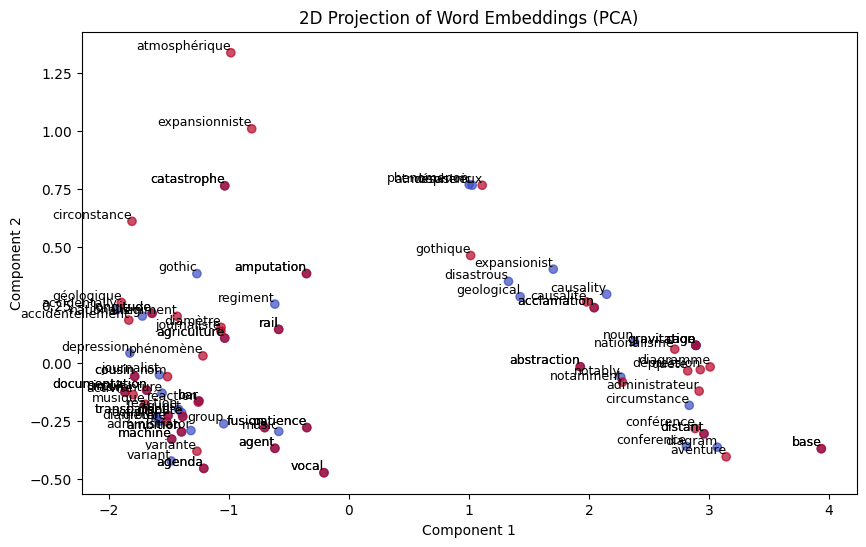

In [119]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_embeddings_2D(model, tokenizer, test_data, method="pca"):
    """
    Visualizes word embeddings from the model in 2D space using PCA or t-SNE.

    Args:
        model: The masked language model (pretrained or fine-tuned).
        tokenizer: Tokenizer corresponding to the model.
        test_data (list of dict): List of cognate pairs from the test split.
        method (str): Dimensionality reduction method ("pca" or "tsne").
    """
    words = []
    embeddings = []

    # Ensure hidden states are returned
    model.config.output_hidden_states = True

    # Extract embeddings
    for pair in test_data:
        english_word, french_word = list(pair.items())[0]
        for word in [english_word, french_word]:
            tokens = tokenizer(word, return_tensors="pt", truncation=True, padding="max_length", max_length=8)
            with torch.no_grad():
                outputs = model(**tokens)
                hidden_states = outputs.hidden_states[-1]       # Get the last hidden layer
                word_embedding = hidden_states.mean(dim=1).squeeze().numpy()        # Mean pooling over tokens
                embeddings.append(word_embedding)
                words.append(word)

    # Convert to NumPy array
    embeddings = np.array(embeddings)

    # Reduce dimensions
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, perplexity=10, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, c=np.arange(len(words)) % 2, cmap="coolwarm")

    # Annotate points with words
    for i, word in enumerate(words):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=9, ha='right', va='bottom')

    plt.title(f"2D Projection of Word Embeddings ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Call function for both models using PCA
visualize_embeddings_2D(pretrained_model, tokenizer, test_data, method="pca")
visualize_embeddings_2D(finetuned_model, tokenizer, test_data, method="pca")

## Test Section ##

In [120]:
from scipy.spatial.distance import cosine

word = "risk"

tokens = tokenizer(word, return_tensors="pt")

with torch.no_grad():
    pre_emb = pretrained_model(**tokens).hidden_states[-1].mean(dim=1).squeeze().detach().numpy()
    fine_emb = finetuned_model(**tokens).hidden_states[-1].mean(dim=1).squeeze().detach().numpy()

similarity = 1 - cosine(pre_emb, fine_emb)
print(f"Cosine similarity between pretrained and fine-tuned embeddings for '{word}': {similarity:.4f}")

Cosine similarity between pretrained and fine-tuned embeddings for 'risk': 1.0000
